# Curva ROC ( Receiver Operating Characteristic )

## Modificación del umbral de decisión

- Un modelo probabilístico calcula la probabildad de que una observación pertenezca a una clase.
- Hasta ahora en clasificación binaria, modelamos $P(Y=1|X=X_i)$. Si esta probabilidad está por encima de 0.5, clasificamos a $X_i$ como perteneciente a la clase 1 o 0 en caso contrario.
- Una vez que realizamos la asignación de clases podemos armar la matriz de confusión, y de la matriz de confusión, calcular los diversos indicadores de performance del modelo.

¿Podemos armar distintas matrices de confusión, modificando el umbral de clasificación?

Podemos, y esto dará origen a distintos modelos, cada uno con su propia matriz de confusión y por lo tanto, distintos valores de sensibilidad, especificidad, etc. 

Armemos un dataset sintético para analizar cómo varían los parámetros de performance del modelo (calculados a partir de la matriz de confusión) en función del umbral.

In [1]:
# Se Cargan Librerias
%reload_ext autoreload
%autoreload 2
import numpy as np
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier

In [2]:
# Importamos helper.py - Script de ayuda Hecho por los Profesores
if not os.path.os.path.isfile('helper.py'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/lab-ml-itba/Regresion-Logistica/master/helper.py',
        filename='helper.py')
import helper

In [3]:
# Se crea dataset sintético
def generate_gaussians(N0,N1,mu0,mu1,s):
    # N0: Cantidad de muestras pertenecientes a la clase 0
    # N1: Cantidad de muestras pertenecientes a la clase 1
    # mu0: Media de las muestras pertenecientes a 0
    # mu1: Media de las muestras pertenecientes a 1
    # s: Desvío estandar de los predictores. Los predictores son independientes.
    sigma=[[s,0],[0,s]]
    np.random.seed(231)
    X=np.vstack([np.random.multivariate_normal(mu0, sigma,N0),np.random.multivariate_normal(mu1, sigma,N1)])
    y=np.hstack([np.zeros(N0),np.ones(N1)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
    return X_train, X_test, y_train, y_test

## Intepretación del dataset

Supongamos que los valores de los predictores de este dataset son los valores de concentración en sangre de dos indicadores.  
En el siguiente gráfico los puntos azules representan valores de los indicadores en personas enfermas.  
Los puntos rojos representan valores de los indicadores en personas sanas.

In [4]:
X_train, X_test, y_train, y_test=generate_gaussians(N0=1000,N1=1000,mu0=[2,5],mu1=[3,3],s=1)

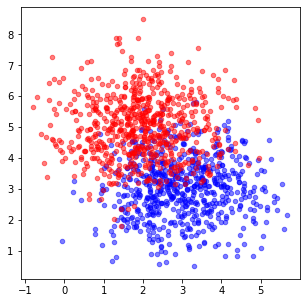

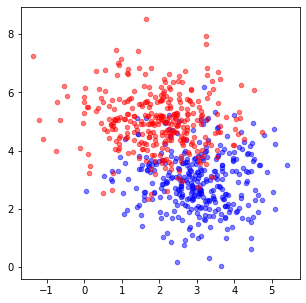

In [5]:
helper.plotBoundary(X_train,y_train)
helper.plotBoundary(X_test,y_test)

# Escribir una función plot_metrics que reciba:

- y_true: Las anotaciones de las clases de cada observacion. El ground truth.
- y_proba: La probabilidad que dió el clasificador de que cada observación pertenezca a la clase 1
- num: cantidad de valores que tomará el threshold
- plot_metrics: si es true, se graficarán las métricas en función del threshold
- plot_ROC: si es true, se graficará la curva ROC

La función devuelve la binary cross entropy y el área bajo la curva ROC para los datos de entrada.

### Preguntas:

- Cuánto vale la binary crossentropy?  
- Cuánto vale el área bajo la curva ROC?  
- Si elegimos un threshold de 0.2:  
    -  ¿Cuánta gente que se haga el test y le haya dado positivo,no tiene la enfermedad?
    -  ¿Cuánta gente que cuyo test de negativo, tiene en realidad la enfermedad?
    -  ¿Cuánta gente que cuyo test de positivo, tiene efectivamente la enfermedad?
    -  ¿Cuánta gente que cuyo test de negativo, no tiene la enfermedad?
    
- Si elegimos un threshold de 0.8:  
    -  ¿Cuánta gente que se haga el test y le haya dado positivo, no tiene la enfermedad?
    -  ¿Cuánta gente que cuyo test de negativo, tiene en realidad la enfermedad?
    -  ¿Cuánta gente que cuyo test de positivo, tiene efectivamente la enfermedad?
    -  ¿Cuánta gente que cuyo test de negativo, no tiene la enfermedad?

### Problema:

Usted es empleado de un sistema de salud que utiliza el test anterior en pacientes para detectar una enfermedad. 

- El costo de realizar este test (de descarte) es despreciable para el sistema de salud.  
- Si alguien se hace el test de descarte y da positivo, tiene que realizarse un test mas caro pero definitivo (detección perfecta) cuyo costo es 2500 pesos. 
- Si el test definitivo da positivo, el paciente deberá realizarse un tratamiento (de detección temprana) cuyo costo es de 2500 pesos.  
- Si el test definitivo da negativo, el paciente no deberá realizarse ningún tratamiento, ya que está sano.
- Si el test de descarte da negativo, pero el paciente estaba enfermo, mas adelante la enfermedad se detectará y deberá realizar un tratamiento (de detección tardía) cuyo costo es de 9500 pesos.
- Si el test de descarte da negativo, y el paciente no estaba enfermo, no hay ningún costo asociado para la empresa.

Pensando solamente en el costo total para el sistema de salud, es decir, cuánto dinero promedio se gasta por paciente, ¿cuál es valor de threshold que minimiza este costo? 

Recomendación: Exprese el costo en función de las distintas métricas estudiadas en ingréselo en la función anterior como una métrica mas. Luego utilice argmin sobre el arreglo de esta nueva métrica para encontrar el threshold que minimiza el costo.

¿Cuánto vale la sensibilidad, la especificidad, el VPP y el VPN del test de descarte para este threshold?

# Función Plot_Metrics()

In [6]:
# La siguiente función grafica las métricas de la matriz de confunsión y la curva ROC.
# Devuelve el area bajo la curva ROC y la loss
def plot_metrics(y_true,y_proba,num=50,plot_metrics=False,plot_ROC=False,plot_costo=False):
    P= np.count_nonzero(np.array(y_true) == 1) #cantidad de observaciones pertenecientes a la clase P (1)
    N= np.count_nonzero(np.array(y_true) == 0) #cantidad de observaciones pertenecientes a la clase N (0)
    costo = np.zeros(num)
    if plot_metrics or plot_costo:
      cond_pos= (P/(P+N))   #Proporción de observaciones positivas (PRIORI)
      cond_neg= (N/(P+N))   #Proporción de observaciones negativas (PRIORI)
      # Reserva de espacio para las métricas
      accuracy=np.zeros(num)
      specificity=np.zeros(num)
      ppv=np.zeros(num)
      npv=np.zeros(num)
      fnr=np.zeros(num)
    sensitivity=np.zeros(num+2) # Se reservan dos lugares mas, para fijar lo thresholds en cero y uno
    fpr=np.zeros(num+2)  # Se reservan dos lugares mas, para fijar lo thresholds en cero y uno
    thresholds=np.linspace(0.01,0.99,num)
    for idx,threshold in enumerate(thresholds):
        y_pred=1*(y_proba>threshold)
        conf_matrix=metrics.confusion_matrix(y_true, y_pred, labels=[0,1])
        TN=conf_matrix[0,0]
        FN=conf_matrix[1,0]
        FP=conf_matrix[0,1]
        TP=conf_matrix[1,1]
        sensitivity[idx+1]= TP/(FN+TP) 
        fpr[idx+1]= FP/(FP+TN) 
        costo[idx] = FP * 2500 + TP * 5000 + 9500 * FN 
        if(plot_metrics or plot_costo):
            accuracy[idx]= (TN+TP)/(N+P) 
            specificity[idx]= TN/(TN+FP) 
            ppv[idx]= TP/(TP+FP) 
            npv[idx]= TN/(TN+FN) 
            fnr[idx]= FN/(FN+TP) 
    # Completo los valores de los extremos.
    sensitivity[0]=1 
    sensitivity[-1]=0
    fpr[0]=1
    fpr[-1]=0 
    # Calculamos Área Bajo la Curva ROC
    roc_auc = metrics.auc(fpr, sensitivity) 
    # Calculamos Binary Cross Entropy
    loss= metrics.log_loss(y_true, y_proba, labels=[0,1]) 
    #Calculamos el Threshold que minimiza el costo
    min_th = (np.argmin(costo))
    if(plot_metrics):
        # Gráfica de las métricas en función del threshold
        plt.figure(figsize=[15,10])
        plt.title("Diagrama de Métricas", fontsize=20,fontweight="bold")
        plt.plot(np.linspace(0,1,num),accuracy, label='Accuracy')
        plt.plot(np.linspace(0,1,num),sensitivity[1:-1], label='Sensitivity or True Positive Rate or Recall')
        plt.plot(np.linspace(0,1,num),specificity, label='Specificity')
        plt.plot(np.linspace(0,1,num),ppv, label='Positive Predictive Value or Precision ')
        plt.plot(np.linspace(0,1,num),npv, label='Negative Predictive Value')
        plt.plot(np.linspace(0,1,num),fnr, label='False Negative Rate or Miss Rate')
        plt.plot(np.linspace(0,1,num),fpr[1:-1], label='False Positive Rate or Fall-out')
        plt.plot([0.2,0.2] , [0 ,1] , "y--", label="threshold: 0.2" )
        plt.plot([0.8,0.8] , [0 ,1] , "y--", label="threshold: 0.8" )
        plt.legend()
        plt.ylabel('Metric')
        plt.xlabel('Threshold')
        plt.show()
        print("\nSi elegimos un threshold de 0.2:")
        print("\nRespuesta 1:",1-ppv[20])
        print("Respuesta 2:",1-npv[20])
        print("Respuesta 3:",ppv[20])
        print("Respuesta 4:",npv[20])
        print("\nSi elegimos un threshold de 0.8:")
        print("\nRespuesta 1:",1-ppv[80])
        print("Respuesta 2:",1-npv[80])
        print("Respuesta 3:",ppv[80])
        print("Respuesta 4:",npv[80])
        print("\nAuc_ROC:",roc_auc,"Loss:",loss)
        return
    if(plot_ROC):
        # Gráfica del Área bajo la Curva ROC
        plt.title("Área bajo la Curva-ROC", fontsize=20,fontweight="bold")
        plt.plot(fpr,sensitivity,label="ROC curve. Area={}".format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(color='pink', linestyle='-', linewidth=0.2 , alpha=0.7)
        plt.show()
        print("\nAuc_ROC:",roc_auc)
        return 
    if(plot_costo):
        # Gráfica de las métricas en función del threshold
        plt.title("Diagrama metric-threshold", fontsize=20,fontweight="bold")
        plt.plot(np.linspace(0,1,num),costo, label='Costo para el sistema de salud')
        x=(np.argmin(costo)/100)  #0.32
        y=costo.min()
        plt.plot(x,y , "rD", label="threshold que minimiza el costo"  )
        plt.ylabel('Metric')
        plt.xlabel('Threshold')
        plt.legend()
        plt.grid(color='pink', linestyle='-', linewidth=0.2 , alpha=0.7)
        plt.show()
        print("\nThreshold que minimiza el costo:",min_th/100), 
        print("Sensibilidad:",sensitivity[min_th]), 
        print("Especificidad:",specificity[min_th]), 
        print("PPV:",ppv[min_th])
        print("NPV:",npv[min_th])  
        return 


# generación de observaciones

Ahora utilice el siguiente código para generar observaciones y graficar las métricas solicitadas para el caso: 

$$N0=10000,N1=2000,mu0=[-4,4],mu1=[4,-4],s=20$$

In [7]:
X_train, X_test, y_train, y_test=generate_gaussians(N0=10000,N1=2000,mu0=[-4,4],mu1=[4,-4],s=20)

clf=SGDClassifier(loss='log',penalty=None,max_iter=1000,tol=1e-6,learning_rate='adaptive',eta0=0.1)
clf.fit(X_train,y_train)
y_train_pred_proba=clf.predict_proba(X_train)[:,1]

# Graficamos: Métricas, auc_ROC y Costo

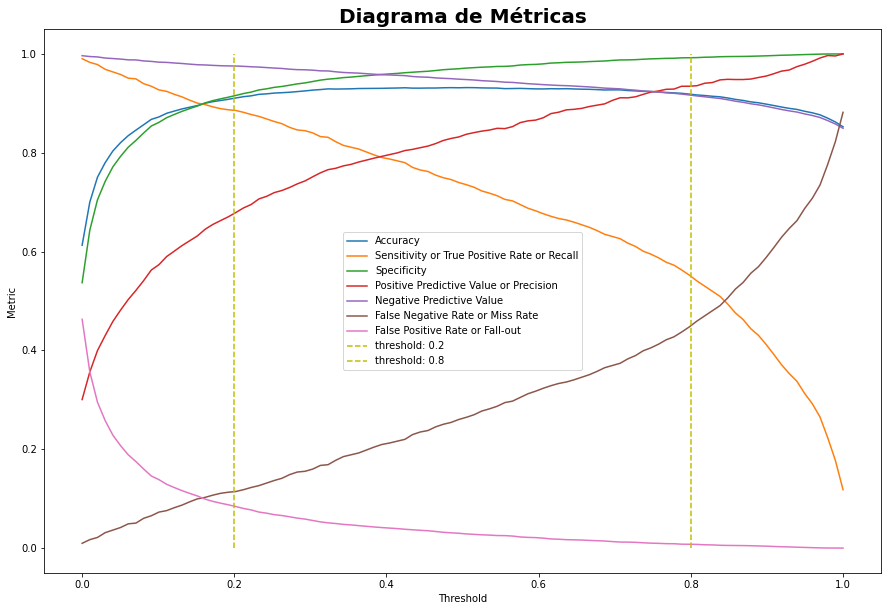


Si elegimos un threshold de 0.2:

Respuesta 1: 0.32098061573546177
Respuesta 2: 0.024498886414253906
Respuesta 3: 0.6790193842645382
Respuesta 4: 0.9755011135857461

Si elegimos un threshold de 0.8:

Respuesta 1: 0.0643500643500643
Respuesta 2: 0.08508880627839732
Respuesta 3: 0.9356499356499357
Respuesta 4: 0.9149111937216027

Auc_ROC: 0.9620687357540858 Loss: 0.1697519539589924


In [8]:
plot_metrics(y_train,y_train_pred_proba,num=100,plot_metrics=True,plot_ROC=False,plot_costo=False)

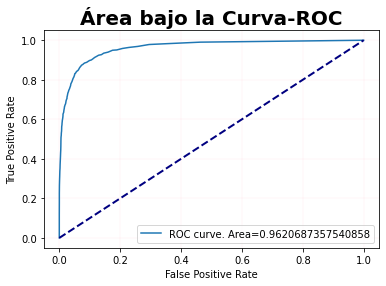


Auc_ROC: 0.9620687357540858


In [9]:
plot_metrics(y_train,y_train_pred_proba,num=100,plot_metrics=False,plot_ROC=True,plot_costo=False)

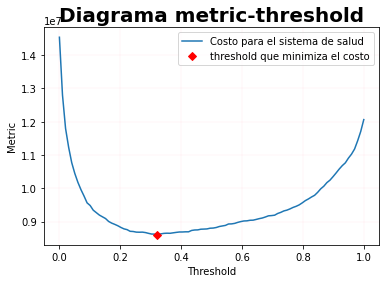


Threshold que minimiza el costo: 0.32
Sensibilidad: 0.8327137546468402
Especificidad: 0.9489171023151606
PPV: 0.7657534246575343
NPV: 0.965501519756839


In [10]:
plot_metrics(y_train,y_train_pred_proba,num=100,plot_metrics=False,plot_ROC=False,plot_costo=True)